<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Home%20Furniture%20US/Sarima%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sqlalchemy
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.5 MB/s 
     |████████████████████████████████| 9.8 MB 28.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
from sqlalchemy import create_engine
from urllib.parse import quote
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 998 kB/s 


In [20]:
# Data from DWH
db = 'mysql+pymysql://warehouse_user:%s@partner1.coresight.com:3306/warehouse_db?charset=utf8mb4' %quote('DW@core.local')
cnx = create_engine(db).raw_connection()

dftmp = pd.read_sql_query("""
select mth, amt from dwh_uscensusretailtrade where catcode='442'
""", con=cnx)

dftmp['ds'] = pd.to_datetime(dftmp['mth'], format='%Y-%m') + MonthEnd(1)
df = dftmp[['ds', 'amt']]
df.columns = ['ds', 'y']

cnx.close()

In [7]:
df.to_excel('Data MarketSize - USCensus.xlsx')

In [21]:
df = df[['ds', 'y']][df['ds'] > '2010-01-01']

In [22]:
df = df.set_index('ds')
df.index.freq = 'M'

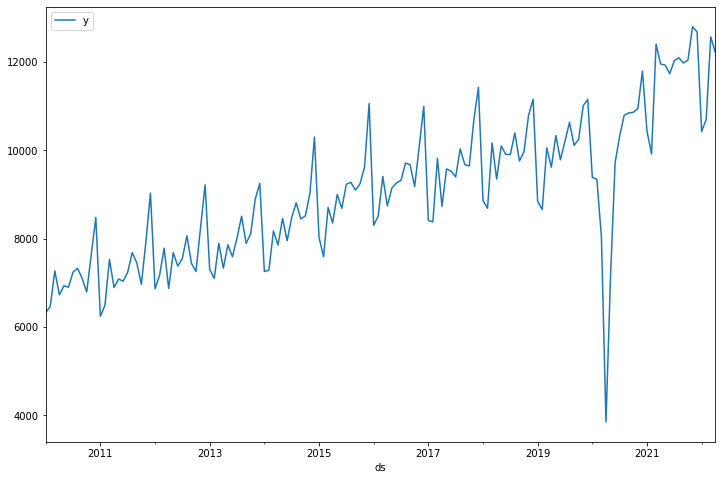

In [25]:
df.plot(figsize=(12,8))

In [11]:
res = seasonal_decompose(df, model='additive')

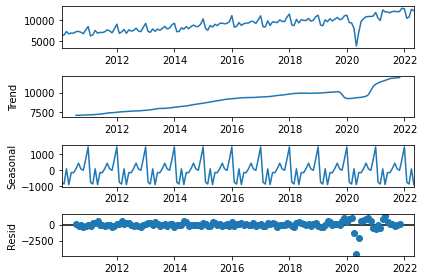

In [12]:
res.plot();

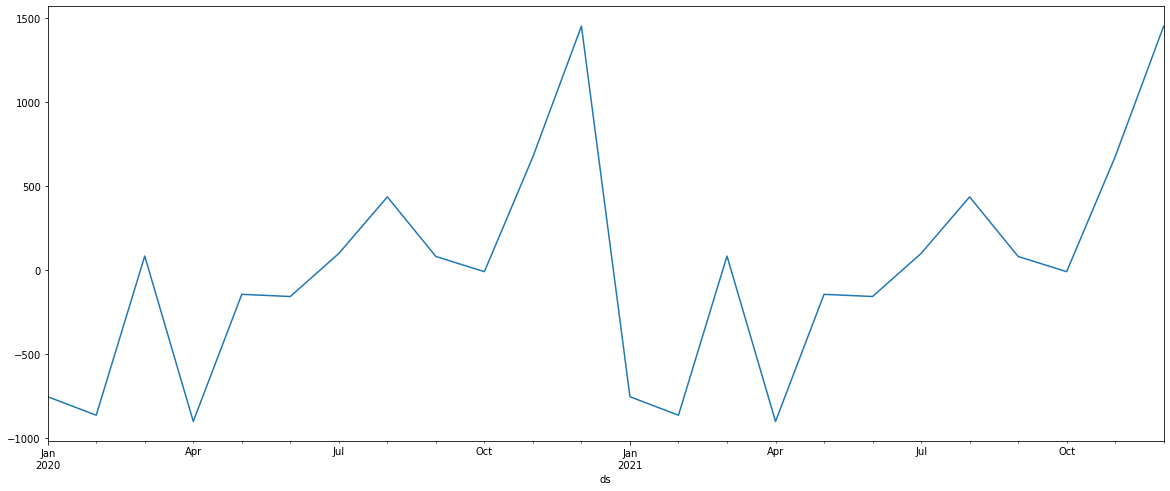

In [13]:
res.seasonal["2020":"2021"].plot(figsize=(20,8));

In [24]:
auto_arima(y=df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2454.461, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2400.798, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2419.152, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2452.696, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2451.357, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2381.862, Time=0.93 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2365.472, Time=1.93 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2364.665, Time=0.83 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2422.669, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2364.870, Time=2.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2409.734, Time=0.73 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2362.938, Time=0.59 sec
 ARIMA(0,1,0)(0,0,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  148
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -1161.955
Date:                            Thu, 23 Jun 2022   AIC                           2339.911
Time:                                    12:10:53   BIC                           2363.834
Sample:                                         0   HQIC                          2349.631
                                            - 148                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8952      0.091      9.841      0.000       0.717       1.073
ar.L2         -0.4103      0.075     -5.489      0.000      -0.557      -0.264
ar.L3          0.2086      0.098      2.120      0.034       0.016       0.401
ma.L1         -0.9224      0.071    -12.936      0.000      -1.062      -0.783
ar.S.L12       0.9765      0.117      8.320      0.000       0.746       1.207
ar.S.L24       0.0088      0.100      0.088      0.930      -0.188       0.206
ma.S.L12      -0.8249      0.134     -6.176      0.000      -1.087      -0.563
sigma2      3.231e+05   2.11e+04     15.312      0.000    2.82e+05    3.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               768.90
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -1.73
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
sxorder = (2,1,0)
sxsorder = (2,0,1,12)

In [37]:
def testmodel(train, test):
    print('train end: ', train.index[-1])
    
    print('\n---------\n')

    model = SARIMAX(endog=train, order=sxorder, seasonal_order=sxsorder).fit(disp=0)

    test['ypred'] = model.predict(start=test.index[0], end=test.index[-1])

    mape = round(np.mean(np.abs((test['y'] - test['ypred'])/test['y'])),3)
    accuracy = round((1-mape)*100,1)
    print('Accuracy: ', accuracy)

    print('\n---------\n')

    dffcast = model.get_forecast(steps=24).summary_frame()
    dffcast['bounds'] = round((pd.to_numeric(dffcast['mean_ci_upper'])-pd.to_numeric(dffcast['mean_ci_lower']))/pd.to_numeric(dffcast['mean'])*100)
    print(dffcast[['mean_ci_lower', 'mean', 'mean_ci_upper', 'bounds']])
    
    print('\n---------\n')
    
    test['mape'] = (1-round(abs(test['y'] - test['ypred'])/test['y'],6))*100
    test[['y', 'ypred', 'mape']]
    print(test[['y', 'ypred', 'mape']])

In [29]:
df[:-48]

,y
ds,
2010-01-31,6324.0
2010-02-28,6468.0
2010-03-31,7271.0
2010-04-30,6729.0
2010-05-31,6932.0
...,...
2017-12-31,11422.0
2018-01-31,8864.0
2018-02-28,8686.0


In [38]:
testmodel(df[:-48], df[-48:])

train end:  2018-04-30 00:00:00

---------

Accuracy:  90.8

---------

y           mean_ci_lower          mean  mean_ci_upper  bounds
2018-05-31    9457.430587   9952.942692   10448.454798    10.0
2018-06-30    9389.135485   9930.013482   10470.891480    11.0
2018-07-31    9294.164761   9863.884779   10433.604797    12.0
2018-08-31    9751.762137  10400.220193   11048.678249    12.0
2018-09-30    9385.128600  10080.486987   10775.845374    14.0
2018-10-31    9339.210792  10072.472012   10805.733231    15.0
2018-11-30   10230.289787  11010.325841   11790.361894    14.0
2018-12-31   10841.974232  11662.478164   12482.982096    14.0
2019-01-31    8498.331636   9355.466047   10212.600458    18.0
2019-02-28    8308.054040   9202.643292   10097.232543    19.0
2019-03-31    9600.128337  10530.104625   11460.080912    18.0
2019-04-30    8829.000379   9792.517380   10756.034381    20.0
2019-05-31    9146.057299  10339.525477   11532.993655    23.0
2019-06-30    9042.704758  10318.452292   1159

In [39]:
model = SARIMAX(endog=df, order=sxorder, seasonal_order=sxsorder).fit(disp=0)
pred = model.get_forecast(steps=51).summary_frame()

In [40]:
dffin = pd.DataFrame(index=pd.date_range(df.index[0], pred.index[-1], freq='M'))

In [41]:
dffin['y'] = df['y']
dffin['ypred'] = pred['mean']

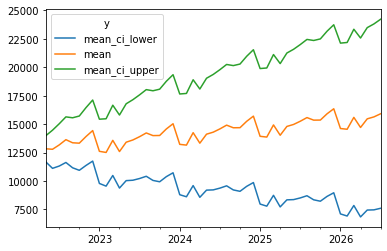

In [42]:
pred[['mean_ci_lower', 'mean', 'mean_ci_upper']].plot()

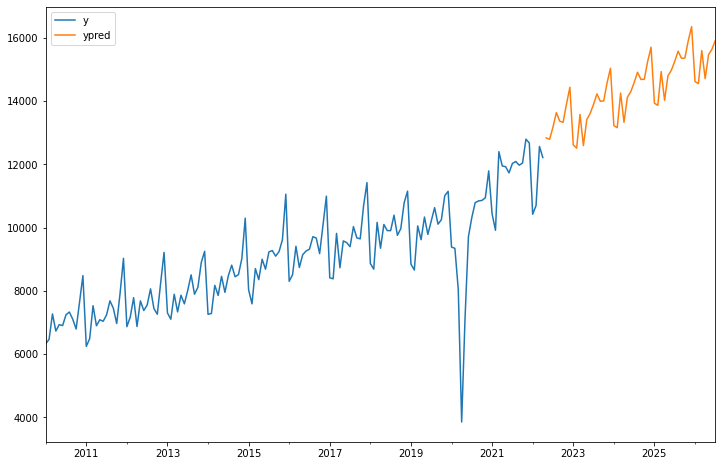

In [43]:
dffin.plot(figsize=(12,8))

In [ ]:
pred

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-03-31,28298.310030,752.168592,26824.086679,29772.533381
2022-04-30,26988.427903,873.917302,25275.581466,28701.274340
2022-05-31,27140.333086,965.712108,25247.572136,29033.094037
2022-06-30,27284.805536,1129.062458,25071.883782,29497.727289
2022-07-31,27189.046484,1206.655671,24824.044827,29554.048142
2022-08-31,27483.304942,1308.597458,24918.501053,30048.108831
2022-09-30,27103.003230,1400.118136,24358.822110,29847.184350
2022-10-31,27957.907249,1476.797700,25063.436943,30852.377554
2022-11-30,27155.236840,1559.745124,24098.192572,30212.281107
2022-12-31,29147.444653,1632.639915,25947.529220,32347.360086


In [44]:
pred = pred[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred.columns = ['Projection', 'Lower Bound', 'Upper Bound']
pred.to_excel('Furniture Projected MarketSize - USCensus.xlsx')